# Example 2: Markov Stability applied to multiscale graph

In [1]:
import pygenstability as pgs
from pygenstability import plotting
from pygenstability.pygenstability import evaluate_NVI
import scipy.sparse as sp

import matplotlib.pyplot as plt
import networkx as nx

from multiscale_example import create_graph

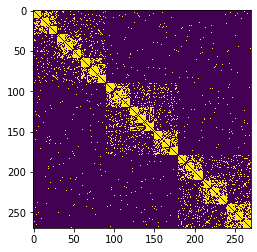

In [2]:
A, coarse_scale_id, middle_scale_id, fine_scale_id = create_graph() 

# Create nx graph
G = nx.from_numpy_array(A)

# Compute spring layout
pos_G = nx.layout.spring_layout(G, seed=1)


# plot matrix
plt.figure()
plt.imshow(A, interpolation="nearest")


In [3]:
# run markov stability and identify optimal scales
results = pgs.run(
    sp.csgraph.csgraph_from_dense(A),
    min_scale=-1.25,
    max_scale=0.75,
    n_scale=50,
    n_tries=20,
    constructor="continuous_combinatorial",
    with_spectral_decomp=True,
    n_workers=4
)

INFO:pygenstability.pygenstability:Precompute constructors...
100%|██████████| 50/50 [00:00<00:00, 57.72it/s]
INFO:pygenstability.pygenstability:Optimise stability...
100%|██████████| 50/50 [00:08<00:00,  6.11it/s]
INFO:pygenstability.pygenstability:Apply postprocessing...
100%|██████████| 50/50 [00:02<00:00, 24.36it/s]
INFO:pygenstability.pygenstability:Compute ttprimes...
INFO:pygenstability.pygenstability:Identify optimal scales...


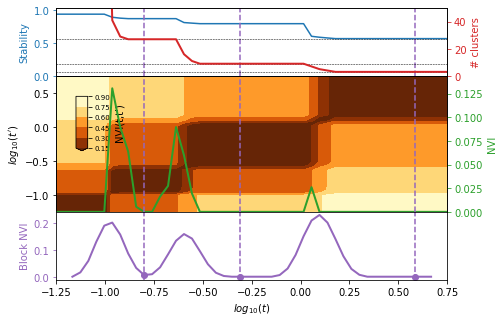

In [4]:
# plots results
plt.figure(figsize=(7, 5))
axes = plotting.plot_scan(results, figure_name=None)
axes[3].set_ylim(0, 50)
axes[3].axhline(3, ls="--", color="k", zorder=-1, lw=0.5)
axes[3].axhline(9, ls="--", color="k", zorder=-1, lw=0.5)
axes[3].axhline(27, ls="--", color="k", zorder=-1, lw=0.5)

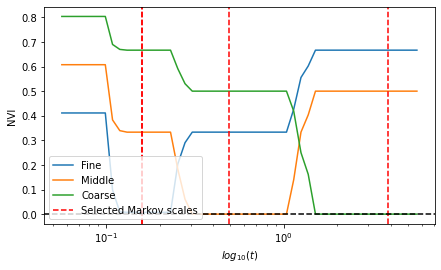

In [5]:
# compare MS partitions to ground truth with NVI
def _get_NVI(ref_ids):
    return [
        evaluate_NVI([0, i + 1], [ref_ids] + results["community_id"])
        for i in range(len(results["scales"]))
    ]

NVI_scores_fine = _get_NVI(fine_scale_id)
NVI_scores_middle = _get_NVI(middle_scale_id)
NVI_scores_coarse = _get_NVI(coarse_scale_id)
scales = results["scales"]

# plot NVI scores
fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(scales, NVI_scores_fine, label="Fine")
ax.plot(scales, NVI_scores_middle, label="Middle")
ax.plot(scales, NVI_scores_coarse, label="Coarse")

# plot selected partitions
selected_partitions = results["selected_partitions"]
ax.axvline(
    x=results["scales"][selected_partitions[0]],
    ls="--",
    color="red",
    label="Selected Markov scales",
)
for i in selected_partitions:
    ax.axvline(x=results["scales"][i], ls="--", color="red")

ax.set(xlabel=r"$log_{10}(t)$", ylabel="NVI")
plt.axhline(0, c="k", ls="--")
ax.legend(loc=3)
plt.xscale("log")


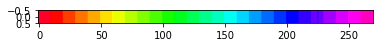

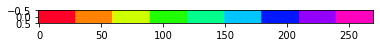

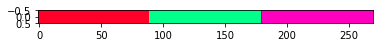

In [6]:
for i in results["selected_partitions"]:
    data = results["community_id"][i]
    plt.figure()
    plt.imshow([data / max(data)], aspect=10.0, cmap="gist_rainbow")